## Viterbi Alignment

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  23/03/23
+ ###### Requires: pyspch v0.7   

Content:
- Evaluate the sequence effect of the HMM model


In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
from pyspch.stats import GMM
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm


In [3]:
#@title Auxiliary functions

def get_pickle(filename):
    picklefile = pyspch.read_fobj(filename)    
    #picklefile = open(filename, 'rb')
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

def plot_probs(probs, labels,  fig, iax=2, x0=0., title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## !! only works properly for starting frame = 0
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,linewidths=1,linecolor='k')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.])
        fig.axes[iax].legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

In [4]:
# Helper routines for TIMIT test samples
#
timit_test_files =  ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236'] 

def extract_timit_data(name='', feature_args=None,
                          timit_root='https://homes.esat.kuleuven.be/~spchlab/data/timit/'):
    '''
    extracts waveform and metadata for a named TIMIT file:
    
    wavdata  wav data
    sr     sample_rate
    spg    spectrogram
    ftrs   feature extraction according to feature_args
    txt    utterance transcription
    wrd    wrd segmentation
    phn    phn segmentation
    lab    phn-label alignment
    '''
    # audio and feature extraction
    wavdata, sr = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
    spg = pyspch.sp.feature_extraction(wavdata, sample_rate=sr)
    # transcription + word segmentation 
    #txt = pyspch.read_txt(timit_root + 'segmentation/' + name + ".txt")
    #txt = re.sub('[?!.,;]', '', ' '.join(txt[0].lower().split()[2:]))
    wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sr)   
    txt = ' '.join(wrd['seg'])
    # get reference segmentation and labels , phone segmentation (+ as index)
    phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sr,xlat='timit61_timit41')

    return(wavdata,sr,spg,txt,wrd,phn)

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

## 1. Setting Up

### Feature Extraction
MFCC26=  MFCC13 + Deltas + mean-variance normalization, (defined by feature_args).

### GMM models
Available models are (training in timit-3.ipynb notebook):      
- **S41_D26_G8_FULL_1.pkl**         (FrameRecog: 53%) # S41= 41 classes/states, D26 = 26 dim features, G8 = 8 Gaussians, FULL_1 = training database + version number
- **S41_D26_G64_FULL_1.pkl**        (FrameRecog: 56%)

In [13]:
# task setup
timit_root = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
root_url = timit_root
#
# define feature extraction: MFCC13 + delta's + mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
#clf_GMM = get_pickle(gmm_root+"S41_D26_G8_MINI_1.pkl")   # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
#clf_GMM = get_pickle(gmm_root+"S41_D26_G64_FULL_1.pkl")   # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
clf_GMM = get_pickle(gmm_root+"S41_D26_G8_FULL_1.pkl") 
phn_set= clf_GMM.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

## 2. Run Example File

In [6]:
# choose an example from 0 .. 4 
example_no = 0
#
# 1. select a TIMIT test example
# 2. extract all timit data (wavdata+meta) for a named file
# 3. do the feature extraction
# 4. convert segmentation to label sequence
#
name = timit_test_files[example_no]
wavdata, sr, spgdata, txt, seg_wrd, seg_phn = extract_timit_data(name=name)
ftrs = pyspch.sp.feature_extraction(wavdata, **feature_args)
labels = pyspch.seg2lbls(seg_phn, n_frames=ftrs.shape[1],pad_lbl='sil')
frames = None
#

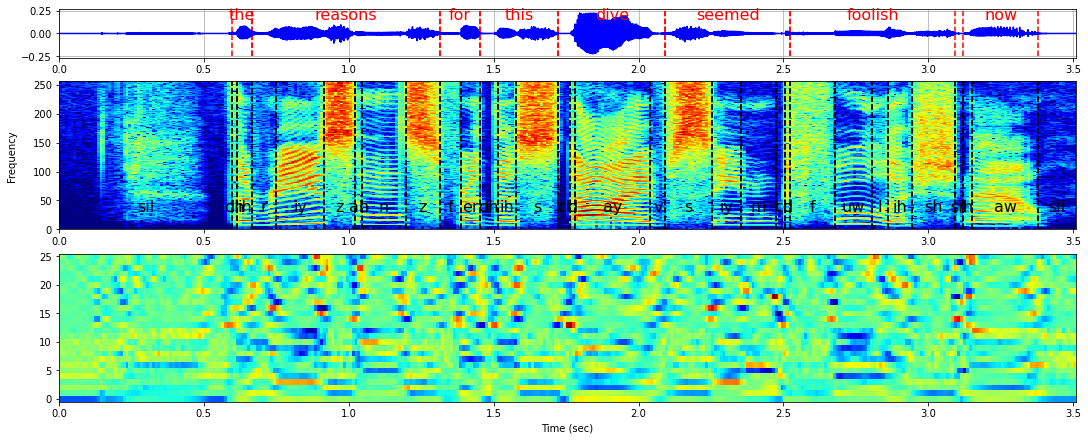

In [7]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
##############################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,
                                 frames=frames, sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=1, ypos=.15, color='k') 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=wavdata,rate=sr))

### FRAME Recognition

In [75]:
# select phones and frames for the plots: specify times below and extract phones from the selected segment
times = np.array([1.32,2.1]) # time selection in seconds
shift=0.01
frames= (times/shift).astype('int')
frame_sel = slice(frames[0],frames[1])
#
seg_phn_sel = seg_phn   # or for selection seg_phn[(seg_phn['t0']<frames[1]*shift) & (seg_phn['t1']>frames[0]*shift)]
phn_sel, indx_sel = select_phones_idx((seg_phn_sel['seg'],['sil']),phn_set,SORTED=True)

In [76]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
# compute posterior probs in the model
y_gmm_prob = clf_GMM.predict_proba(X=ftrs.T,priors=[1]*41)
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(y_gmm_prob, axis=1)
y_gmm_lab = [phn_set[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=features.T)
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == labels[i] for i in range(len(labels))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(labels)))

Frame Recognition Rate (for full utterance): 52.71 %


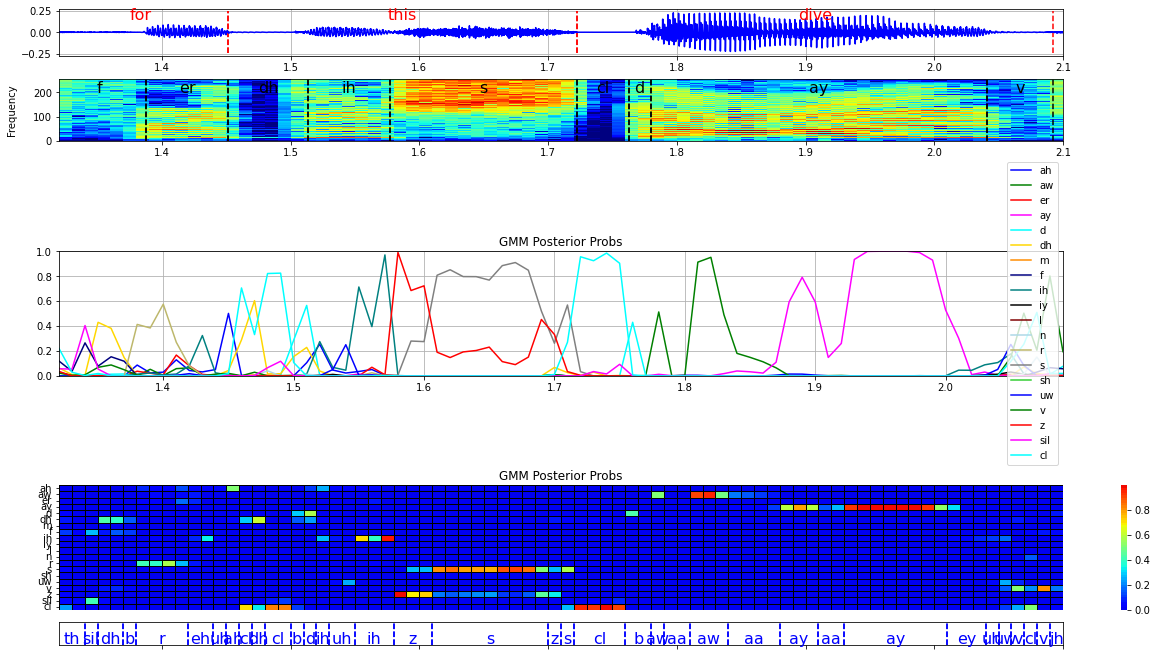

In [77]:
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=1,row_heights=[1.5,2,4,4,.75],
                                 frames=frames, sample_rate=sr, figsize=(16,9), img_ftrs=[None,None])
fig.add_seg_plot(seg_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="line", title="GMM Posterior Probs")
plot_probs(y_gmm_prob[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="img", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_seg, iax=4, ypos=.25, Lines=True, color='b') # predicted labels
fig

### Ergodic Phone Recognizer

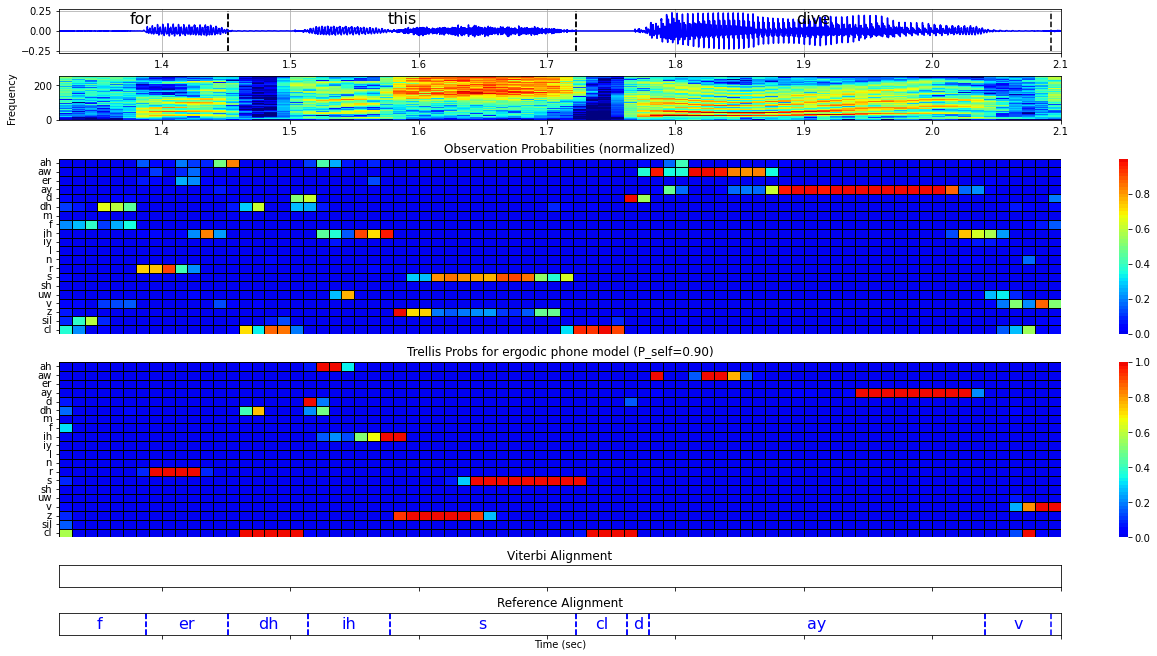

Frame Recognition Rate: 42.31 %


In [122]:
X = ftrs[:,frame_sel].T
P_self = .9
obs_probs = clf_GMM.predict_prob(X)
hmm1 = libhmm.HMM(prob_style="lin",obs_model=clf_GMM,states=phn_set)
hmm1.init_topology("ergodic",selfprob=P_self)
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(X)
y_vit_lbl = hmm1.states[trellis1.backtrace()]
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
# show only phones in reference transcription
phn_sel, idx_sel = select_phones_idx((seg_phn_sel['seg']),phn_set,SORTED=True)
# show all phones in referenced transcription and recognized
# phn_sel, idx_sel = select_phones_idx((seg_phn_sel['seg'],y_vit_lbl),phn_set,SORTED=True)

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(16,9),row_heights=[1,1,4,4,.5,.5],
                  img_ftrs=[None,None,None,None])
tr_probs_sel = trellis1.probs[:, idx_sel]
obs_probs_sel = obs_probs[:,idx_sel]
obs_probs_prt = obs_probs_sel/np.sum(obs_probs_sel,axis=1,keepdims=True)
plot_probs(obs_probs_prt,fig=fig,iax=2,labels=phn_sel,style="img",title="Observation Probabilities (normalized)")
plot_probs(tr_probs_sel,fig=fig,labels=phn_sel,iax=3,style="img",title="Trellis Probs for ergodic phone model (P_self=%.2f)"%P_self)
fig.add_seg_plot(seg_wrd,iax=0,ypos=0.8,color='k')
fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b',title='Viterbi Alignment')
fig.add_seg_plot(seg_phn,iax=5,ypos=0.5,color='b',title='Reference Alignment')
display(fig)
n_corr = np.sum([y_vit_lbl[i] == labels[frame_sel][i] for i in range(len(y_vit_lbl))])
print("Frame Recognition Rate: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))

In [118]:
len(y_vit_lbl)

351

In [12]:
def tmat_from_transcription(phn_seq,phn_set,probstyle='lin',eps=0.):
    '''
    Create a transition matrix accepting all phone transitions in a phn_seq
    allowing for a pseudo Viterbi Alignment
    The transition matrix contains 0 and 1 values

    Sentences are forced to start or end in silence
    '''
    n_phones = len(phn_set)
    trans_mat = np.ones((n_phones,n_phones))*eps
    phn_set = list(phn_set)
    for i in range(n_phones): trans_mat[i,i]=1.
    idx = [ phn_set.index(phn) for phn in phn_seq ]
    for i in range(0,len(idx)-1):
        trans_mat[ idx[i], idx[i+1] ] = 1
    init_mat = np.ones(n_phones)*eps
    init_mat[ idx[0] ] = 1.
    end_states = np.array([idx[-1]])
    return(trans_mat,init_mat,end_states)

def select_sub_GMM(clf,classes):
    clf_out = GMM(n_components=clf.n_components,max_iter =clf.max_iter,classes=classes)
    cl_idx = [ clf.classes.index(cl) for cl in classes ]
    clf_out.gmm = [ clf.gmm[i] for i in cl_idx ]  
    return(clf_out)

In [92]:
def make_viterbi_graph(phn_seq,phn_set):
    ''' 
    makes an HMM Graph to do a Viterbi Alignment on phn_seq
    it is implement with a transition matrix with 0's and 1's
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_seq = len(phn_seq)
    obs_indx = np.zeros(n_seq,dtype='int')
    trans_mat = np.eye(n_seq,dtype='float32')
    init_mat = np.zeros(n_seq,dtype='float32')
    
    for i  in range(n_seq): 
        obs_indx[i] = phn2idx[phn_seq[i]]

    for i in range(n_seq-1):
        trans_mat[i,i+1] = 1.
        
    init_mat[0] = 1.0
    end_states = np.array([n_seq-1])
    return(obs_indx,trans_mat,init_mat,end_states)

### Pseudo Viterbi Alignment

In [93]:
# pseudo-viterbi over the full phone set
#transcript = seg_phn['seg']
#trans_mat,init_mat,end_states = tmat_from_transcription(transcript,phn_set,eps=1.e-20)
#hmm2 = libhmm.HMM(prob_style="lin",obs_model=clf_GMM,states=phn_set,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# viterbi Alignment
transcript = seg_phn[(seg_phn['t0']<frames[1]*shift) & (seg_phn['t1']>frames[0]*shift)]['seg'].tolist()
obs_indx, trans_mat,init_mat,end_states = make_viterbi_graph(transcript,phn_set)
hmm2 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=clf_GMM,states=transcript,transmat=trans_mat,initmat=init_mat,end_states=end_states)

In [111]:
ftrs.shape,frame_sel

((26, 351), slice(132, 210, None))

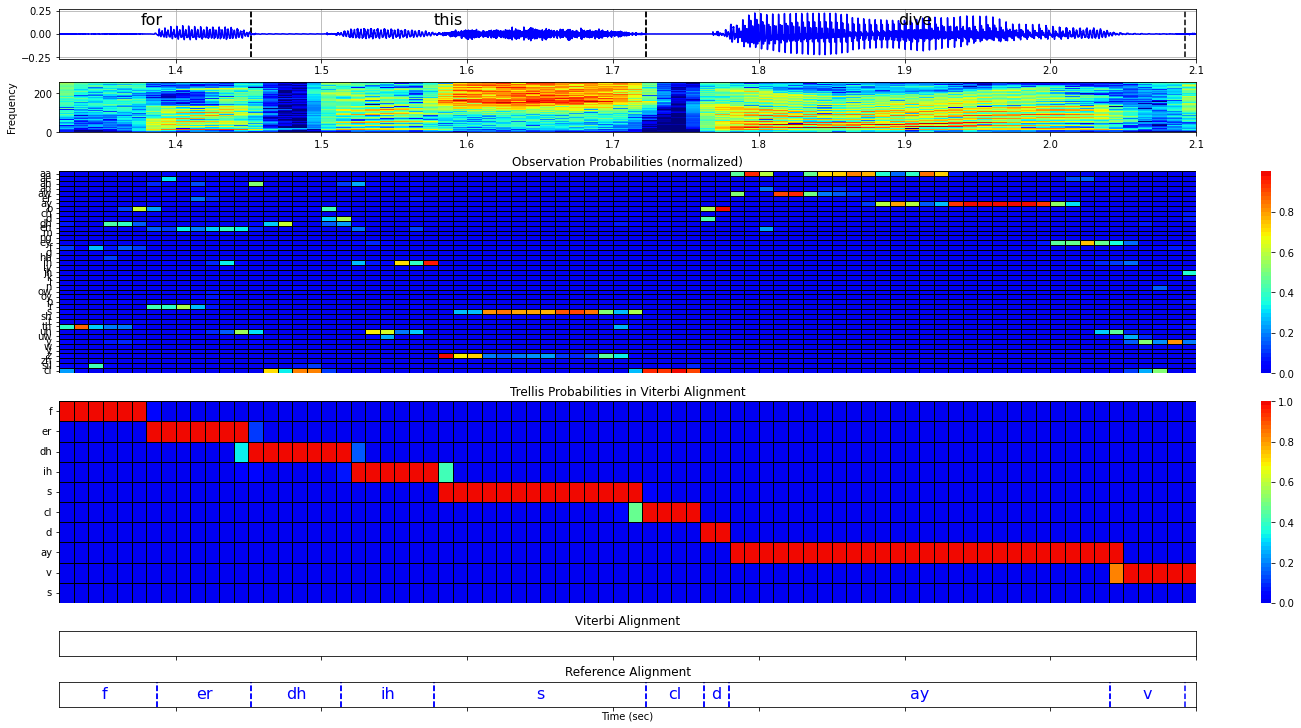

Frame Recognition Rate: 96.15 %


In [120]:
X = ftrs[:,frame_sel].T
obs_probs = clf_GMM.predict_prob(X)
trellis2=libhmm.Trellis(hmm2,Normalize=True)
trellis2.viterbi_pass(X)
# recognize from the trellis
y_vit_lbl = hmm2.states[trellis2.backtrace()]
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
#phn_sel, idx_sel = select_phones_idx((seg_phn_sel['seg'],y_vit_lbl),phn_set,SORTED=True)

fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spgdata,frames=frames,sample_rate=sr,figsize=(18,10),row_heights=[1,1,4,4,.5,.5],
                  img_ftrs=[None,None,None,None])
obs_probs = obs_probs/np.sum(obs_probs,axis=1,keepdims=True)
tr_probs = trellis2.probs
plot_probs(obs_probs,fig=fig,iax=2,labels=phn_set,style="img",title="Observation Probabilities (normalized)")
plot_probs(tr_probs,fig=fig,labels=transcript,iax=3,style="img",title="Trellis Probabilities in Viterbi Alignment")
fig.add_seg_plot(seg_wrd,iax=0,ypos=0.8,color='k')

fig.add_seg_plot(y_vit_seg,iax=4,ypos=0.5,color='b',title='Viterbi Alignment')
fig.add_seg_plot(seg_phn,iax=5,ypos=0.5,color='b',title='Reference Alignment')
display(fig)
n_corr = np.sum([y_vit_lbl[i] == labels[frame_sel][i] for i in range(len(y_vit_lbl))])
print("Frame Recognition Rate: %.2f %%" % (100.*n_corr/len(y_vit_lbl)))